In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd

In [2]:
corn = pd.read_csv('raw/corn by country.csv')
rice = pd.read_csv('raw/rice by country.csv')
wheat = pd.read_csv('raw/wheat by country.csv')
soya = pd.read_csv('raw/soya by country.csv')
roots = pd.read_csv('raw/roots and tubers by country.csv')

## 1. Nutrition Grading Model

In [3]:
# all types of crops
dfs = [corn,rice,wheat,soya,roots]
merged_df = dfs[0]

for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on=['Country or Area', 'Element', 'Year', 'Unit'], how='outer')

# Total Crop production and area harvested of the world
prod = merged_df[(merged_df['Country or Area'] == 'World') & (merged_df['Element'] == 'Production')].reset_index(drop=True)
area = merged_df[(merged_df['Country or Area'] == 'World') & (merged_df['Element'] == 'Area harvested')].reset_index(drop=True)

print(prod)
print(area)

  Country or Area     Element  Year    Unit    Corn Value   Rice Value  \
0           World  Production  2018  tonnes  1.147622e+09  521594098.0   

   Wheat Value   Soya Value  Root Value  
0  734045174.0  348712311.0  10530548.0  
  Country or Area         Element  Year Unit   Corn Value   Rice Value  \
0           World  Area harvested  2018   ha  193733568.0  131794917.0   

   Wheat Value   Soya Value  Root Value  
0  214291888.0  124921956.0   1430272.0  


In [4]:
data = {
    'Crops': ['Rice', 'Corn', 'Wheat', 'Soya', 'Roots and Tubers'],
    'Production(t)': [prod['Rice Value'][0], prod['Corn Value'][0], prod['Wheat Value'][0], prod['Soya Value'][0], prod['Root Value'][0]]
    }
production = pd.DataFrame(data)
data ={'Crops': ['Rice', 'Corn', 'Wheat', 'Soya', 'Roots and Tubers'],
    'Area(ha)': [area['Rice Value'][0], area['Corn Value'][0], area['Wheat Value'][0], area['Soya Value'][0], area['Root Value'][0]]
}
area_harv = pd.DataFrame(data)

# The calorie content of crops are referred
data ={'Crops': ['Rice', 'Corn', 'Wheat', 'Soya', 'Roots and Tubers'],
    'Crop Calorie(Kcal/t)': [3460000, 1060000, 3390000, 4460000, 860000]
}
calorie = pd.DataFrame(data)

yield_crop = pd.merge(production, area_harv, on=['Crops'], how='outer')
yield_crop = pd.merge(yield_crop, calorie, on=['Crops'], how='outer')
yield_crop['Crop Yield(t/ha)'] = yield_crop['Production(t)']/yield_crop['Area(ha)']
yield_crop['Calorie Yield(kcal/ha)'] = yield_crop['Crop Yield(t/ha)']*yield_crop['Crop Calorie(Kcal/t)']
print(yield_crop)

              Crops  Production(t)     Area(ha)  Crop Calorie(Kcal/t)  \
0              Rice   5.215941e+08  131794917.0               3460000   
1              Corn   1.147622e+09  193733568.0               1060000   
2             Wheat   7.340452e+08  214291888.0               3390000   
3              Soya   3.487123e+08  124921956.0               4460000   
4  Roots and Tubers   1.053055e+07    1430272.0                860000   

   Crop Yield(t/ha)  Calorie Yield(kcal/ha)  
0          3.957619            1.369336e+07  
1          5.923712            6.279135e+06  
2          3.425445            1.161226e+07  
3          2.791441            1.244983e+07  
4          7.362619            6.331852e+06  


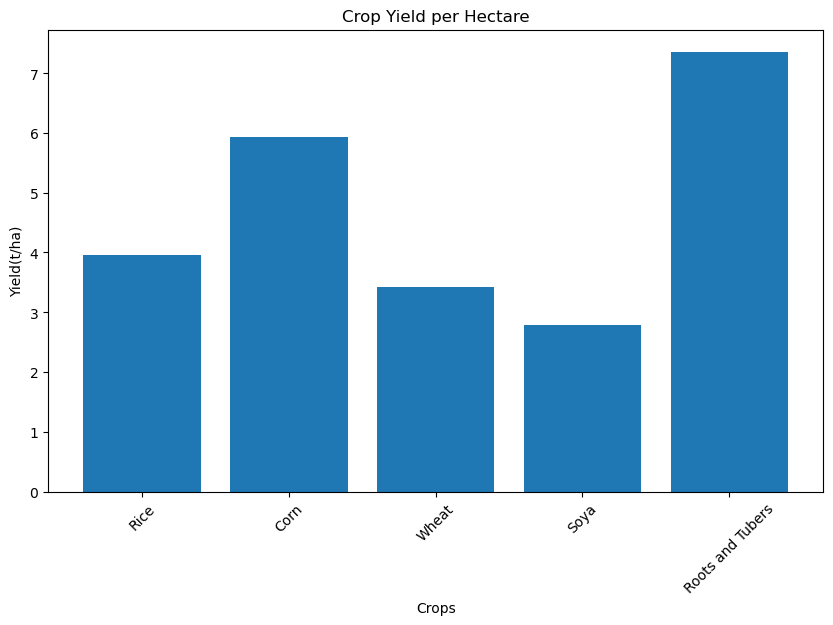

In [5]:
plt.figure(figsize=(10, 6))
plt.bar(yield_crop['Crops'], yield_crop['Crop Yield(t/ha)'])
plt.title('Crop Yield per Hectare')
plt.xlabel('Crops')
plt.ylabel('Yield(t/ha)')
plt.xticks(rotation=45)
plt.show()

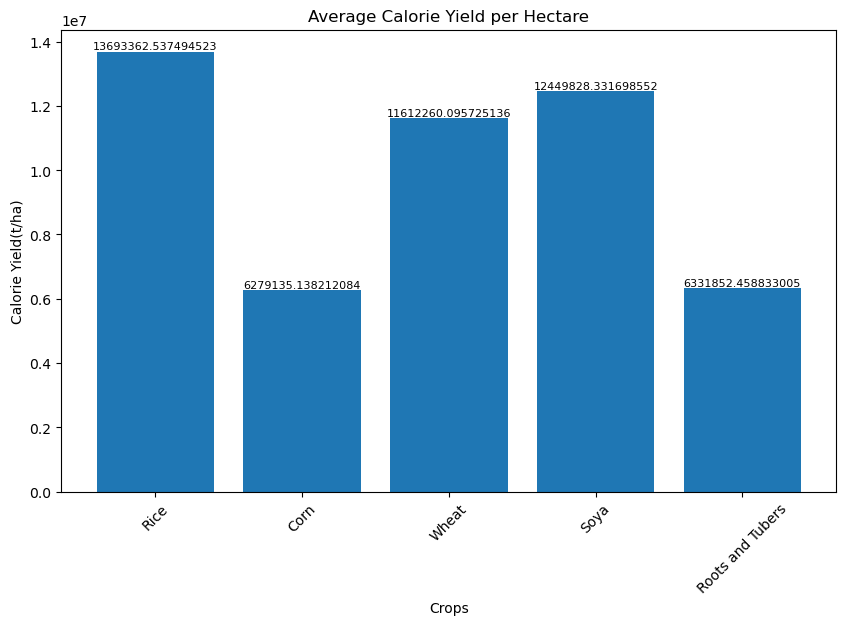

In [6]:
plt.figure(figsize=(10, 6))
plt.bar(yield_crop['Crops'], yield_crop['Calorie Yield(kcal/ha)'])
plt.title('Average Calorie Yield per Hectare')
plt.xlabel('Crops')
plt.ylabel('Calorie Yield(t/ha)')
plt.xticks(rotation=45)

for i, value in enumerate(yield_crop['Calorie Yield(kcal/ha)']):
    plt.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=8)

plt.show()

## 2. Planting Area Distribution Model

In [7]:
# we selected 97 countries (crop production) to represent the whole world
crops = pd.read_csv('raw/crops in the major agricultural countries.csv')

In [8]:
crops['%Rice'] = crops['%Rice'].str.rstrip('%').astype(float)/100.0
crops['%Corn'] = crops['%Corn'].str.rstrip('%').astype(float)/100.0
crops['%Wheat'] = crops['%Wheat'].str.rstrip('%').astype(float)/100.0
crops['%Soya'] = crops['%Soya'].str.rstrip('%').astype(float)/100.0
crops['%Root'] = crops['%Root'].str.rstrip('%').astype(float)/100.0

# classify dataframe by element names
# production dataframe
prod_val = merged_df[merged_df['Element'] == 'Production'].reset_index(drop=True)
prod_val = prod_val.iloc[:, [0, 4, 5, 6, 7, 8]]


new_column_names = {
    'Corn Value': 'Corn Prod',
    'Rice Value': 'Rice Prod',
    'Wheat Value': 'Wheat Prod',
    'Soya Value': 'Soya Prod',
    'Root Value': 'Root Prod',
}
prod_val = prod_val.rename(columns=new_column_names)
print(prod_val)

               Country or Area     Corn Prod    Rice Prod   Wheat Prod  \
0                        World  1.147622e+09  521594098.0  734045174.0   
1                     Americas  5.779548e+08   25855484.0  113083333.0   
2             Northern America  4.063356e+08    6783417.0   83055740.0   
3     United States of America  3.924508e+08    6783417.0   51286540.0   
4                         Asia  3.615650e+08  470497398.0  328220218.0   
..                         ...           ...          ...          ...   
229  Wallis and Futuna Islands           NaN          NaN          NaN   
230      Saint Kitts and Nevis           NaN          NaN          NaN   
231                    Tokelau           NaN          NaN          NaN   
232                     Tuvalu           NaN          NaN          NaN   
233                  Singapore           NaN          NaN          NaN   

       Soya Prod   Root Prod  
0    348712311.0  10530548.0  
1    302429121.0    910476.0  
2    130930830.0  

In [9]:
merged = [crops, prod_val]
merged_crops = merged[0]

for df in merged[1:]:
    merged_crops = pd.merge(merged_crops, df, on=['Country or Area'], how='left')
    
# replace NAN with 0.00001 in case of divided by 0
merged_crops = merged_crops.fillna(0.00001)
print(merged_crops)

         Country or Area      Rice(ha)  %Rice    Corn(ha)  %Corn  \
0                  China  2.031746e+07   0.28  42158995.0   0.12   
1          United States  7.868400e+05   0.05  33079360.0   0.20   
2                  India  2.968150e+07   0.45   9200000.0   0.10   
3                 Brazil  1.241496e+06   0.30  16121147.0   0.15   
4                 Russia  1.201780e+05   0.01   2375641.0   0.09   
..                   ...           ...    ...         ...    ...   
92             Dominican  1.284670e+05   0.95     26111.0   0.05   
93  United Arab emirates  1.000000e-05   0.00       314.0   1.00   
94   Antigua and Barbuda  1.000000e-05   0.00        47.0   1.00   
95                  Guam  1.000000e-05   0.90        21.0   0.05   
96              Maldives  1.000000e-05   0.90        29.0   0.05   

       Wheat(ha)  %Wheat      Soya(ha)  %Soya  Roots and tubers(ha)  %Root  \
0   2.426879e+07    0.24  7.973877e+06   0.24            3407.00000   0.12   
1   1.602775e+07    0.30  3

In [10]:
# current harvest area for one country = rice area + corn area + wheat area + soya area + root area
merged_crops['total_area'] = merged_crops.apply(lambda row: row['Rice(ha)'] + row['Corn(ha)'] + row['Wheat(ha)'] + row['Soya(ha)'] + row['Roots and tubers(ha)'], axis=1)

# new distributed harvest area = current total harvest area * crop percentage defined by us
merged_crops['New Corn Area'] = merged_crops.apply(lambda row: row['total_area']*row['%Corn'], axis=1)
merged_crops['New Rice Area'] = merged_crops.apply(lambda row: row['total_area']*row['%Rice'], axis=1)
merged_crops['New Wheat Area'] = merged_crops.apply(lambda row: row['total_area']*row['%Wheat'], axis=1)
merged_crops['New Soya Area'] = merged_crops.apply(lambda row: row['total_area']*row['%Soya'], axis=1)
merged_crops['New Root Area'] = merged_crops.apply(lambda row: row['total_area']*row['%Root'], axis=1)

# new crop production = current crop production * new distributed area / current harvest area
merged_crops['New Corn Prod'] = merged_crops['Corn Prod']*merged_crops['New Corn Area']/merged_crops['Corn(ha)']
merged_crops['New Rice Prod'] = merged_crops['Rice Prod']*merged_crops['New Rice Area']/merged_crops['Rice(ha)']
merged_crops['New Wheat Prod'] = merged_crops['Wheat Prod']*merged_crops['New Wheat Area']/merged_crops['Wheat(ha)']
merged_crops['New Soya Prod'] = merged_crops['Soya Prod']*merged_crops['New Soya Area']/merged_crops['Soya(ha)']
merged_crops['New Root Prod'] = merged_crops['Root Prod']*merged_crops['New Root Area']/merged_crops['Roots and tubers(ha)']

# new calorie = new crop production * calorie yield of this crop (calculated before)
merged_crops['New Corn Calorie'] = merged_crops['New Corn Area']*yield_crop['Calorie Yield(kcal/ha)'][1]
merged_crops['New Rice Calorie'] = merged_crops['New Rice Area']*yield_crop['Calorie Yield(kcal/ha)'][0]
merged_crops['New Wheat Calorie'] = merged_crops['New Wheat Area']*yield_crop['Calorie Yield(kcal/ha)'][2]
merged_crops['New Soya Calorie'] = merged_crops['New Soya Area']*yield_crop['Calorie Yield(kcal/ha)'][3]
merged_crops['New Root Calorie'] = merged_crops['New Root Area']*yield_crop['Calorie Yield(kcal/ha)'][4]


In [11]:
merged_crops['Original Calorie'] = merged_crops.apply(lambda row: row['Rice(ha)']*yield_crop['Calorie Yield(kcal/ha)'][0]+row['Corn(ha)']*yield_crop['Calorie Yield(kcal/ha)'][1]+row['Wheat(ha)']*yield_crop['Calorie Yield(kcal/ha)'][2]+row['Soya(ha)']*yield_crop['Calorie Yield(kcal/ha)'][3]+row['Roots and tubers(ha)']*yield_crop['Calorie Yield(kcal/ha)'][4],axis=1)
merged_crops['New Calorie'] = merged_crops.apply(lambda row: row['New Corn Calorie']+row['New Rice Calorie']+row['New Wheat Calorie']+row['New Soya Calorie']+row['New Root Calorie'], axis=1)
merged_crops['ratio'] = merged_crops.apply(lambda row: (row['New Calorie']-row['Original Calorie'])/row['Original Calorie'], axis=1)

In [12]:
merged_crops = merged_crops.rename(columns={'Country or Area': 'Country'})
print(merged_crops)

                 Country      Rice(ha)  %Rice    Corn(ha)  %Corn  \
0                  China  2.031746e+07   0.28  42158995.0   0.12   
1          United States  7.868400e+05   0.05  33079360.0   0.20   
2                  India  2.968150e+07   0.45   9200000.0   0.10   
3                 Brazil  1.241496e+06   0.30  16121147.0   0.15   
4                 Russia  1.201780e+05   0.01   2375641.0   0.09   
..                   ...           ...    ...         ...    ...   
92             Dominican  1.284670e+05   0.95     26111.0   0.05   
93  United Arab emirates  1.000000e-05   0.00       314.0   1.00   
94   Antigua and Barbuda  1.000000e-05   0.00        47.0   1.00   
95                  Guam  1.000000e-05   0.90        21.0   0.05   
96              Maldives  1.000000e-05   0.90        29.0   0.05   

       Wheat(ha)  %Wheat      Soya(ha)  %Soya  Roots and tubers(ha)  ...  \
0   2.426879e+07    0.24  7.973877e+06   0.24            3407.00000  ...   
1   1.602775e+07    0.30  3.565

In [13]:
# rename the country for official name for gpd plot
country_mapping = {
    'China': 'China',
    'United States': 'United States of America',
    'India': 'India',
    'Brazil': 'Brazil',
    'Russia': 'Russia',
    'Canada': 'Canada',
    'Ukraine': 'Ukraine',
    'Bangladesh': 'Bangladesh',
    'Argentina': 'Argentina',
    'Viet Nam': 'Vietnam',
    'France': 'France',
    'Australia': 'Australia',
    'Turkey': 'Turkey',
    'Pakistan': 'Pakistan',
    'Mexico': 'Mexico',
    'Poland': 'Poland',
    'myanmar': 'Myanmar',
    'Iran': 'Iran',
    'Egypt': 'Egypt',
    'Philippines': 'Philippines',
    'Romania': 'Romania',
    'South Africa': 'South Africa',
    'kazakhstan': 'Kazakhstan',
    'Spain': 'Spain',
    'Japan': 'Japan',
    'Serbia': 'Serbia',
    'Republic of Korea': 'South Korea',
    'Belarus': 'Belarus',
    'Syria': 'Syria',
    'Austria': 'Austria',
    'Democratic People\'s Republic of Korea': 'North Korea',
    'Cambodia': 'Cambodia',
    'Colombia': 'Colombia',
    'Peru': 'Peru',
    'Finland': 'Finland',
    'Chile': 'Chile',
    'Sudan': 'Sudan',
    'venezuela': 'Venezuela',
    'Croatia': 'Croatia',
    'Sri Lanka': 'Sri Lanka',
    'Lithuania': 'Lithuania',
    'Mali': 'Mali',
    'Saudi Arabia': 'Saudi Arabia',
    'Kenya': 'Kenya',
    'Uganda': 'Uganda',
    'Uruguay': 'Uruguay',
    'azerbaijan': 'Azerbaijan',
    'Ghana': 'Ghana',
    'Netherlands': 'Netherlands',
    'Paraguay': 'Paraguay',
    'Zambia': 'Zambia',
    'Bolivia': 'Bolivia',
    'Bosnia and Herzegovina': 'Bosnia and Herzegovina',
    'Chad': 'Chad',
    'Portugal': 'Portugal',
    'Zimbabwe': 'Zimbabwe',
    'Guatemala': 'Guatemala',
    'Senegal': 'Senegal',
    'Cuba': 'Cuba',
    'Switzerland': 'Switzerland',
    'Nicaragua': 'Nicaragua',
    'Angola': 'Angola',
    'Togo': 'Togo',
    'Georgia': 'Georgia',
    'Honduras': 'Honduras',
    'Slovenia': 'Slovenia',
    'Guyana': 'Guyana',
    'Armenia': 'Armenia',
    'Haiti': 'Haiti',
    'Rwanda': 'Rwanda',
    'Sierra leone': 'Sierra Leone',
    'Burundi': 'Burundi',
    'Costa rica': 'Costa Rica',
    'Gambia': 'Gambia',
    'Guinea-Bissau': 'Guinea-Bissau',
    'Luxembourg': 'Luxembourg',
    'Lebanon': 'Lebanon',
    'Mongolia': 'Mongolia',
    'Bhutan': 'Bhutan',
    'Liberia': 'Liberia',
    'namibia': 'Namibia',
    'Cyprus': 'Cyprus',
    'Jordan': 'Jordan',
    'Mauritania': 'Mauritania',
    'Belize': 'Belize',
    'Papua New Guinea': 'Papua New Guinea',
    'Qatar': 'Qatar',
    'Kuwait': 'Kuwait',
    'Sao Tome and Principe': 'Sao Tome and Principe',
    'Jamaica': 'Jamaica',
    'brunei': 'Brunei',
    'Puerto Rico': 'Puerto Rico',
    'Dominican': 'Dominican Republic',
    'United Arab emirates': 'United Arab Emirates',
    'Antigua and Barbuda': 'Antigua and Barbuda',
    'Guam': 'Guam',
    'maldives': 'Maldives'
}

merged_crops['Country'] = merged_crops['Country'].replace(country_mapping)

/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_21275/829799728.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


                     Country         ratio
0                      China  1.401350e-01
1   United States of America  1.975698e-02
2                      India -1.356857e-02
3                     Brazil  5.961978e-02
4                     Russia -4.431257e-02
..                       ...           ...
92        Dominican Republic  7.086948e-02
93      United Arab Emirates -9.621776e-08
94       Antigua and Barbuda -6.428157e-07
95                      Guam  1.047773e+00
96                  Maldives  1.046918e+00

[97 rows x 2 columns]


/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_21275/829799728.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(world[world['ratio'].notnull()].geometry.centroid.x,
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_21275/829799728.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world[world['ratio'].notnull()].geometry.centroid.y,


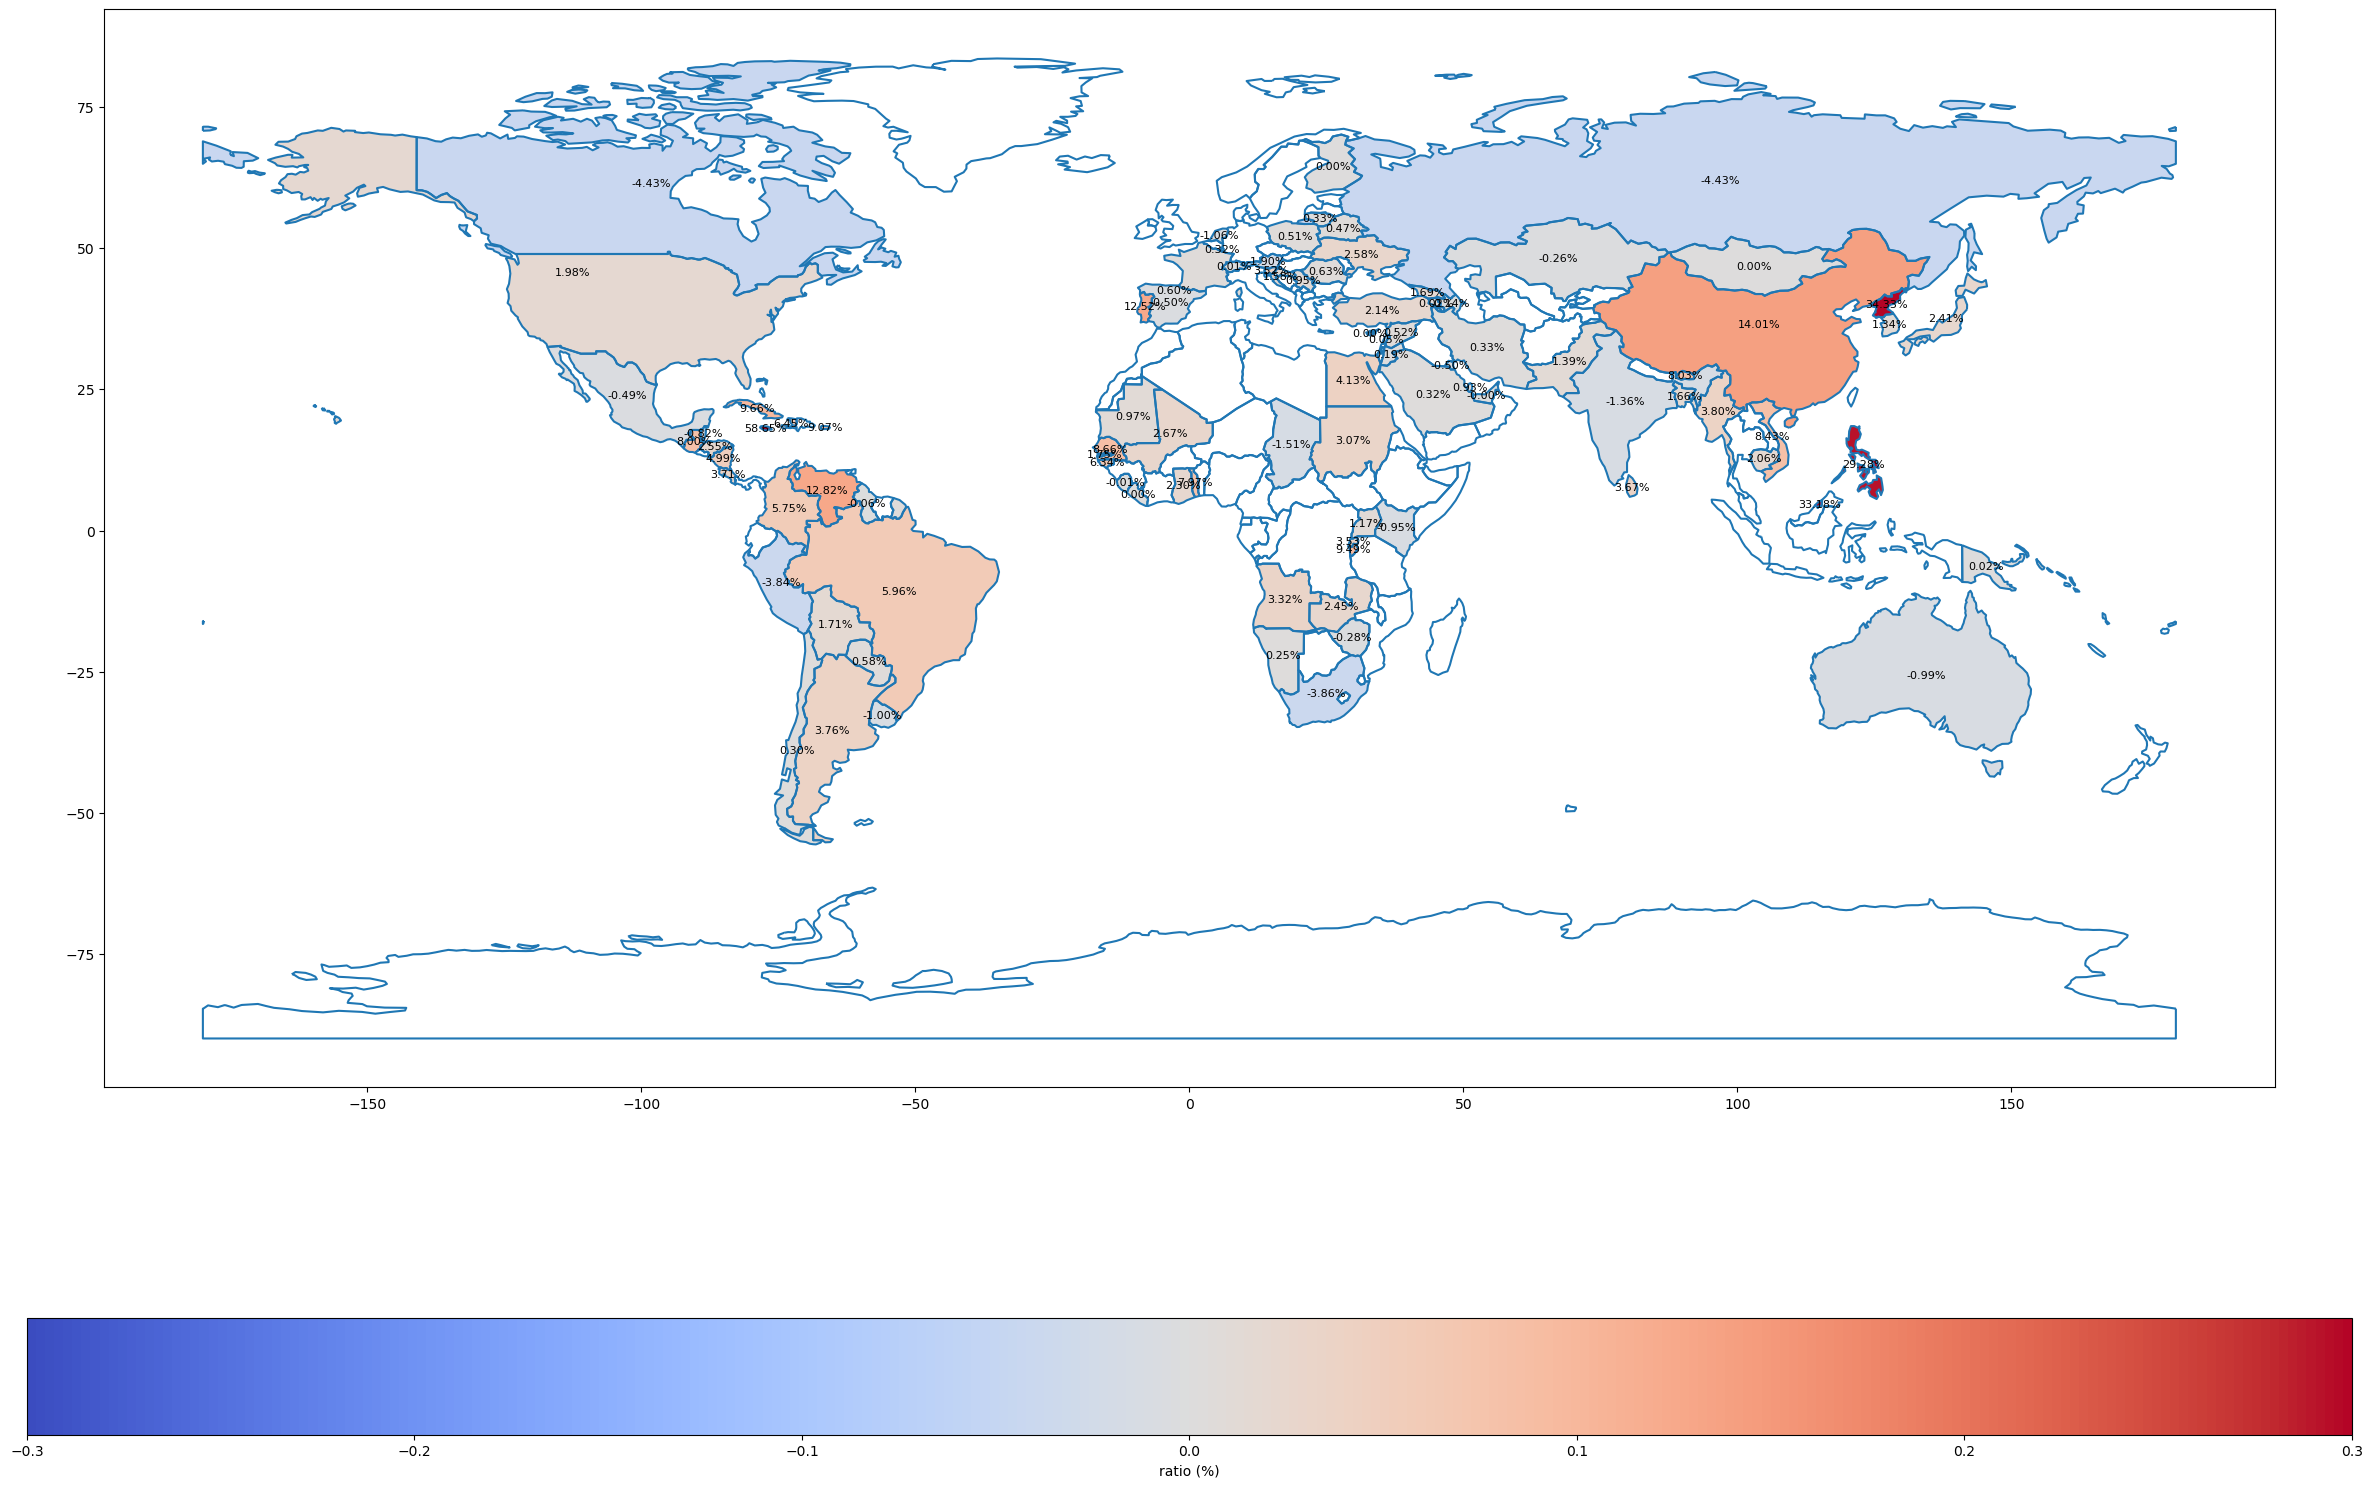

In [14]:
# Plot the figure on the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ratio = merged_crops[['Country','ratio']]
print(ratio)

world = world.merge(ratio, how='left', left_on='name', right_on='Country')

fig, ax = plt.subplots(1, 1, figsize=(30, 20))

world.boundary.plot(ax=ax)

vmin, vmax = -0.3,0.3
world[world['ratio'].notnull()].plot(column='ratio', ax=ax, legend=True,
                                                   legend_kwds={'label': "ratio (%)", 'orientation': "horizontal"},
                                    vmin=vmin, vmax=vmax, cmap='coolwarm')

for x, y, label in zip(world[world['ratio'].notnull()].geometry.centroid.x,
                       world[world['ratio'].notnull()].geometry.centroid.y,
                       world[world['ratio'].notnull()]['ratio']*100):
    ax.text(x, y, f"{label:.2f}%", fontsize=8, ha='center', va='center')

plt.show()


## 3. Production Cost Model

In [15]:
from scipy.stats import poisson

# Define parameters for the exponential distribution
rate = 1000  # Rate parameter (lambda), should be positive

exp_values = np.random.exponential(scale=1/rate, size=1000)

# Define parameters for the poisson distribution
lambda_ = 4

pmf_values = poisson.pmf(x, lambda_)


cost = merged_crops[['Country','Rice(ha)','Corn(ha)','Wheat(ha)','Soya(ha)','Roots and tubers(ha)','New Rice Area','New Corn Area','New Wheat Area','New Soya Area','New Root Area']]

# P(A)=\sum_{i=1}^{97}{{AL(A)}_i{a(A)}_i}+\sum_{i=1}^{97}{TP(A)}_i{p(A)}_i+\sum_{i=1}^{97}{{TP(A)}_i{c(A)}_i}
# tmp_r = 0
# for index, row in df.iterrows():
    
# cost['Rice'] = 6*env_coff['Rice(ha)']+5.5*env_coff['Corn(ha)']+4.5*env_coff['Wheat(ha)']+3.5*env_coff['Soya(ha)']+2.5*env_coff['Roots and tubers(ha)']
# cost['Corn'] = 6*env_coff['Rice(ha)']+5.5*env_coff['Corn(ha)']+4.5*env_coff['Wheat(ha)']+3.5*env_coff['Soya(ha)']+2.5*env_coff['Roots and tubers(ha)']
# cost['Wheat'] = 6*env_coff['Rice(ha)']+5.5*env_coff['Corn(ha)']+4.5*env_coff['Wheat(ha)']+3.5*env_coff['Soya(ha)']+2.5*env_coff['Roots and tubers(ha)']
# cost['Soya'] = 6*env_coff['Rice(ha)']+5.5*env_coff['Corn(ha)']+4.5*env_coff['Wheat(ha)']+3.5*env_coff['Soya(ha)']+2.5*env_coff['Roots and tubers(ha)']
# cost['Root'] = 6*env_coff['Rice(ha)']+5.5*env_coff['Corn(ha)']+4.5*env_coff['Wheat(ha)']+3.5*env_coff['Soya(ha)']+2.5*env_coff['Roots and tubers(ha)']


NameError: name 'env_coff' is not defined

## 4. Environmental Impact Coefficient Model

In [16]:
env_coff = merged_crops[['Country','Rice(ha)','Corn(ha)','Wheat(ha)','Soya(ha)','Roots and tubers(ha)','New Rice Area','New Corn Area','New Wheat Area','New Soya Area','New Root Area']]

# environment impact factor =6* Rce Area+5.5*Corn Area+4.5*Wheat Area+3.5*Soya Area+2.5*Root Area
env_coff['Current Environmental Impact'] = 6*env_coff['Rice(ha)']+5.5*env_coff['Corn(ha)']+4.5*env_coff['Wheat(ha)']+3.5*env_coff['Soya(ha)']+2.5*env_coff['Roots and tubers(ha)']
env_coff['New Environmental Impact'] = 6*env_coff['New Rice Area']+5.5*env_coff['New Corn Area']+4.5*env_coff['New Wheat Area']+3.5*env_coff['New Soya Area']+2.5*env_coff['New Root Area']
env_coff['ratio'] = (env_coff['New Environmental Impact']-env_coff['Current Environmental Impact'])/env_coff['Current Environmental Impact']
print(env_coff)

                     Country      Rice(ha)    Corn(ha)     Wheat(ha)  \
0                      China  2.031746e+07  42158995.0  2.426879e+07   
1   United States of America  7.868400e+05  33079360.0  1.602775e+07   
2                      India  2.968150e+07   9200000.0  2.958000e+07   
3                     Brazil  1.241496e+06  16121147.0  2.065254e+06   
4                     Russia  1.201780e+05   2375641.0  2.647205e+07   
..                       ...           ...         ...           ...   
92        Dominican Republic  1.284670e+05     26111.0  1.000000e-05   
93      United Arab Emirates  1.000000e-05       314.0  1.000000e-05   
94       Antigua and Barbuda  1.000000e-05        47.0  1.000000e-05   
95                      Guam  1.000000e-05        21.0  1.000000e-05   
96                  Maldives  1.000000e-05        29.0  1.000000e-05   

        Soya(ha)  Roots and tubers(ha)  New Rice Area  New Corn Area  \
0   7.973877e+06            3407.00000   2.652231e+07   1.13667

/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_21275/1597548296.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_coff['Current Environmental Impact'] = 6*env_coff['Rice(ha)']+5.5*env_coff['Corn(ha)']+4.5*env_coff['Wheat(ha)']+3.5*env_coff['Soya(ha)']+2.5*env_coff['Roots and tubers(ha)']
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_21275/1597548296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_coff['New Environmental Impact'] = 6*env_coff['New Rice Area']+5.5*env_co

/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_21275/2111953325.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  env_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


                     Country         ratio
0                      China -1.201272e-01
1   United States of America -6.822892e-02
2                      India  1.004863e-03
3                     Brazil  7.392149e-02
4                     Russia -6.434283e-02
..                       ...           ...
92        Dominican Republic  1.005132e-02
93      United Arab Emirates  3.184713e-08
94       Antigua and Barbuda  2.127658e-07
95                      Guam  1.054496e+00
96                  Maldives  1.170156e+00

[97 rows x 2 columns]


/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_21275/2111953325.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(env_world[env_world['ratio'].notnull()].geometry.centroid.x,
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_21275/2111953325.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  env_world[env_world['ratio'].notnull()].geometry.centroid.y,


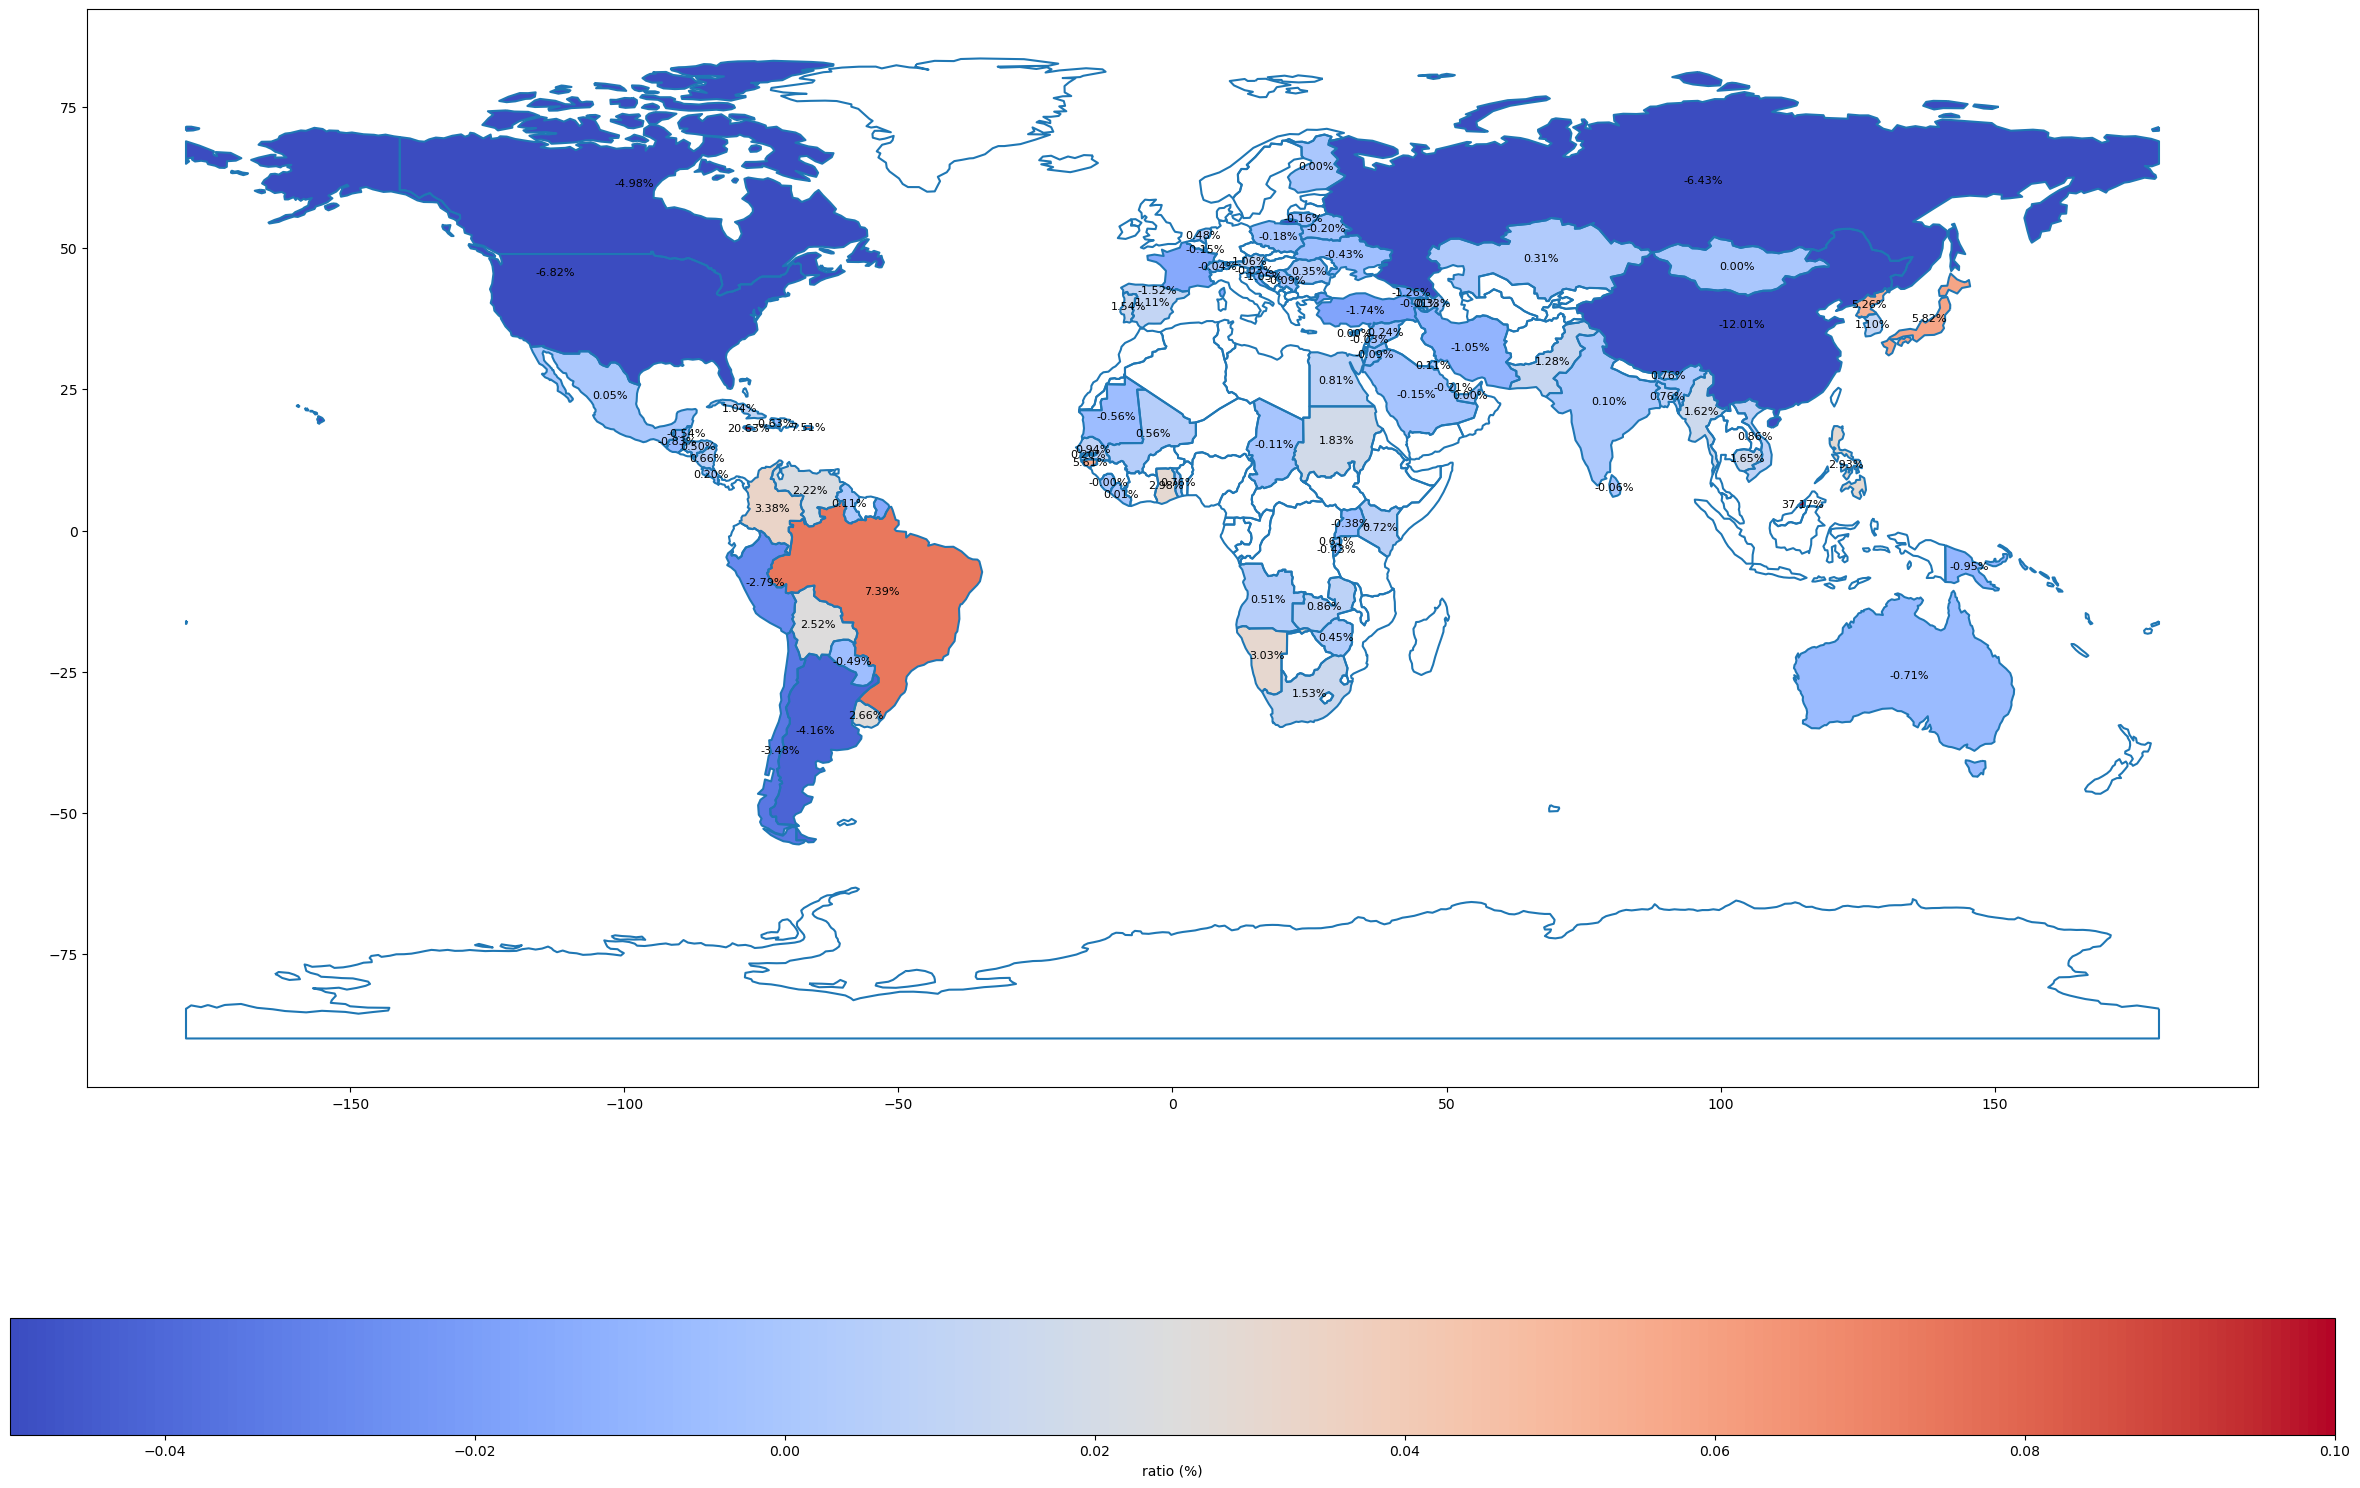

In [17]:
# plot the figure on world map
env_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
env_ratio = env_coff[['Country','ratio']]
print(env_ratio)

env_world = env_world.merge(env_ratio, how='left', left_on='name', right_on='Country')

fig, ax = plt.subplots(1, 1, figsize=(30, 20))

env_world.boundary.plot(ax=ax)

vmin, vmax = -0.05,0.1
env_world[env_world['ratio'].notnull()].plot(column='ratio', ax=ax, legend=True,
                                                   legend_kwds={'label': "ratio (%)", 'orientation': "horizontal"},
                                    vmin=vmin, vmax=vmax, cmap='coolwarm')
                                    

for x, y, label in zip(env_world[env_world['ratio'].notnull()].geometry.centroid.x,
                       env_world[env_world['ratio'].notnull()].geometry.centroid.y,
                       env_world[env_world['ratio'].notnull()]['ratio']*100):
    ax.text(x, y, f"{label:.2f}%", fontsize=8, ha='center', va='center')

plt.show()

## Topsis Model with AHP

In [18]:
# Tools for Topsis Model

def Inter2Max(x, a, b):
    r_x = x.shape[0]  # number of rows in x
    M = max([a - np.min(x), np.max(x) - b])
    posit_x = np.zeros(r_x)  # initialize posit_x with zeros

    for i in range(r_x):
        if x[i] < a:
            posit_x[i] = 1 - (a - x[i]) / M
        elif x[i] > b:
            posit_x[i] = 1 - (x[i] - b) / M
        else:
            posit_x[i] = 1

    return posit_x

# Example usage:
x_example = np.array([1, 2, 3, 4, 5])
a_example = 2
b_example = 4
result = Inter2Max(x_example, a_example, b_example)
print(result)

[0. 1. 1. 1. 0.]


In [19]:
def Mid2Max(x, best):
    M = np.max(np.abs(x - best))
    posit_x = 1 - np.abs(x - best) / M
    return posit_x

# Example usage:
# x_example = np.array([1, 2, 3, 4, 5])
# best_example = 3
# result = Mid2Max(x_example, best_example)
# print(result)

In [20]:
def Min2Max(x):
    posit_x = np.max(x) - x
    # Alternatively, if all elements in x are greater than 0, you can use the following:
    # posit_x = 1 / x
    return posit_x

In [21]:
def Positivization(x, type, i):
    if type == 1:  # Min2Max
        print(f'Column {i} is of type Min2Max, performing positivization.')
        posit_x = Min2Max(x)
        print(f'Positivization of column {i} (Min2Max) completed.')
        print('~~~~~~~~~~~~~~~~~~~~Separator~~~~~~~~~~~~~~~~~~~~')

    elif type == 2:  # Mid2Max
        print(f'Column {i} is of type Mid2Max.')
        best = float(input('Enter the best value: '))
        posit_x = Mid2Max(x, best)
        print(f'Positivization of column {i} (Mid2Max) completed.')
        print('~~~~~~~~~~~~~~~~~~~~Separator~~~~~~~~~~~~~~~~~~~~')

    elif type == 3:  # Inter2Max
        print(f'Column {i} is of type Inter2Max.')
        a = float(input('Enter the lower bound of the interval: '))
        b = float(input('Enter the upper bound of the interval: '))
        posit_x = Inter2Max(x, a, b)
        print(f'Positivization of column {i} (Inter2Max) completed.')
        print('~~~~~~~~~~~~~~~~~~~~Separator~~~~~~~~~~~~~~~~~~~~')

    else:
        print('Invalid type. Please check if the type value is 1, 2, or 3.')

    return posit_x

# Example functions Min2Max, Mid2Max, and Inter2Max need to be implemented similarly to the MATLAB code.
# 
# # Example usage:
# x_example = np.array([1, 2, 3, 4, 5])
# type_example = 1
# i_example = 1
# result = Positivization(x_example, type_example, i_example)
# print(result)

In [51]:
def Topsis(X):
    n, m = X.shape
    print(f'Total {n} evaluation objects, {m} evaluation indicators')

    judge = int(input(f'Do these {m} indicators need positivization? Enter 1 for Yes, 0 for No: '))

    if judge == 1:
        positions = list(map(int, input(f'Enter the columns to be positivized, e.g., 2,3,6: ').split(',')))
        print('Enter the types of these columns (1: Min2Max, 2: Mid2Max, 3: Inter2Max)')
        types = list(map(int, input(f'For example, if the 2nd column is Min2Max, 3rd column is Inter2Max, 6th column is Mid2Max, enter 1,3,2: ').split(',')))

        for i in range(len(positions)):
            X[:, positions[i] - 1] = Positivization(X[:, positions[i] - 1], types[i], positions[i])

        print('Positivized matrix X = ')
        print(X)

    judge_weight = int(input('Do you need to add weights? Enter 1 for Yes, 0 for No: '))

    if judge_weight == 1:
        print(f'Enter {m} weights as a row vector, e.g., 0.25,0.25,0.5')
        weights = list(map(float, input(f'Enter the {m} weights: ').split(',')))
        check_weights = 0

        while check_weights == 0:
            if np.abs(np.sum(weights) - 1) < 1e-6 and len(weights) == m:
                check_weights = 1
            else:
                weights = list(map(float, input(f'Your input is incorrect. Please enter the weights again: ').split()))

    else:
        weights = np.ones(m) / m

#     Z = X / np.tile(np.sum(X * X, axis=0) ** 0.5, (n, 1))
#     print('Normalized matrix Z = ')
#     print(Z)

#     D_P = np.sum(((Z - np.tile(np.max(Z, axis=0), (n, 1))) ** 2) * np.tile(weights, (n, 1)), axis=1) ** 0.5
#     D_N = np.sum(((Z - np.tile(np.min(Z, axis=0), (n, 1))) ** 2) * np.tile(weights, (n, 1)), axis=1) ** 0.5
#     S = D_N / (D_P + D_N)
#     print('Final scores:')
#     stand_S = S / np.sum(S)
#     print(stand_S)
#     sorted_S, index = np.sort(stand_S)[::-1], np.argsort(stand_S)[::-1]
#     print(f'Sorted scores: {sorted_S}')
#     print(f'Index of sorted scores: {index}')

    Z = X / np.sqrt(np.sum(X * X, axis=0))
    print('Normalized matrix Z = ')
    print(Z)

    # Step 4: Calculate distances and scores
    D_P = np.sqrt(np.sum((Z - np.max(Z, axis=0)) ** 2 * weights, axis=1))
    D_N = np.sqrt(np.sum((Z - np.min(Z, axis=0)) ** 2 * weights, axis=1))
    S = D_N / (D_P + D_N)

    # Normalize the scores
    stand_S = S / np.sum(S)
    print('Final scores:')
    print(stand_S)

    # Sort the scores in descending order and get the indices
    sorted_indices = np.argsort(-stand_S)  # -stand_S to sort in descending order
    sorted_S = stand_S[sorted_indices]

    print(f'Sorted scores:{sorted_S}')
    print(f'Indices of sorted scores:{sorted_indices}')
    
    return stand_S
# Example usage:
# X_example = np.random.rand(5, 6)  # Replace this with your actual data
# Topsis(X_example)

In [59]:
current_factor = pd.read_csv('raw/current factor.csv')
cur_factor = current_factor[['Kcal', 'Production Cost', 'Environmental Impact Factor']]

current_matrix = cur_factor.to_numpy()


In [60]:
score = Topsis(current_matrix)

Total 97 evaluation objects, 3 evaluation indicators
Do these 3 indicators need positivization? Enter 1 for Yes, 0 for No: 1
Enter the columns to be positivized, e.g., 2,3,6: 2,3
Enter the types of these columns (1: Min2Max, 2: Mid2Max, 3: Inter2Max)
For example, if the 2nd column is Min2Max, 3rd column is Inter2Max, 6th column is Mid2Max, enter 1,3,2: 1,1
Column 2 is of type Min2Max, performing positivization.
Positivization of column 2 (Min2Max) completed.
~~~~~~~~~~~~~~~~~~~~Separator~~~~~~~~~~~~~~~~~~~~
Column 3 is of type Min2Max, performing positivization.
Positivization of column 3 (Min2Max) completed.
~~~~~~~~~~~~~~~~~~~~Separator~~~~~~~~~~~~~~~~~~~~
Positivized matrix X = 
[[1.49499000e+13 3.73319082e+11 4.78136888e+08]
 [2.95119352e+08 3.74512967e+11 4.90905622e+08]
 [3.17400000e+14 2.94955571e+11 3.67537408e+08]
 [7.79483000e+11 3.74466529e+11 4.90599573e+08]
 [1.28147000e+14 3.67583287e+11 4.41105036e+08]
 [5.55829000e+12 3.74240674e+11 4.88197787e+08]
 [8.10769000e+12 3.73

In [63]:
current_score = pd.DataFrame(score, columns=['Current Score'])
country = current_factor['Country']
cur_df_combined = pd.concat([country, current_score], axis=1)
print(cur_df_combined)

                Country  Current Score
0                Angola       0.009372
1   Antigua and Barbuda       0.009384
2             Argentina       0.014217
3               Armenia       0.009386
4             Australia       0.010473
..                  ...            ...
92              Uruguay       0.009457
93            venezuela       0.009381
94             Viet Nam       0.009741
95               Zambia       0.009390
96             Zimbabwe       0.009381

[97 rows x 2 columns]


In [64]:
new_factor = pd.read_csv('data after processed/new factor.csv')
ne_factor = new_factor[['New Kcal', 'New Production Cost', 'New Environmental Impact Factor']]

new_matrix = ne_factor.to_numpy()

In [65]:
final_score = Topsis(new_matrix)

Total 97 evaluation objects, 3 evaluation indicators
Do these 3 indicators need positivization? Enter 1 for Yes, 0 for No: 1
Enter the columns to be positivized, e.g., 2,3,6: 2,3
Enter the types of these columns (1: Min2Max, 2: Mid2Max, 3: Inter2Max)
For example, if the 2nd column is Min2Max, 3rd column is Inter2Max, 6th column is Mid2Max, enter 1,3,2: 1,1
Column 2 is of type Min2Max, performing positivization.
Positivization of column 2 (Min2Max) completed.
~~~~~~~~~~~~~~~~~~~~Separator~~~~~~~~~~~~~~~~~~~~
Column 3 is of type Min2Max, performing positivization.
Positivization of column 3 (Min2Max) completed.
~~~~~~~~~~~~~~~~~~~~Separator~~~~~~~~~~~~~~~~~~~~
Positivized matrix X = 
[[1.54468000e+13 2.77008239e+11 4.19100807e+08]
 [2.95119352e+08 2.55335839e+11 4.31934483e+08]
 [3.29346000e+14 2.26766215e+11 3.13702393e+08]
 [7.79631000e+11 2.99684372e+11 4.31628462e+08]
 [1.26879000e+14 3.03742304e+11 3.82487106e+08]
 [5.45251000e+12 3.17103938e+11 4.29197873e+08]
 [8.09608000e+12 3.23

In [66]:
new_score = pd.DataFrame(final_score, columns=['New Score'])

                Country  New Score
0                Angola   0.007644
1   Antigua and Barbuda   0.007505
2             Argentina   0.021154
3               Armenia   0.007806
4             Australia   0.010812
..                  ...        ...
92              Uruguay   0.008072
93            venezuela   0.007975
94             Viet Nam   0.009237
95               Zambia   0.007984
96             Zimbabwe   0.007970

[97 rows x 2 columns]


In [71]:
score_com = cur_df_combined.merge(new_score, left_index=True, right_index=True)
score_com['ratio'] = (score_com['New Score']-score_com['Current Score'])/score_com['Current Score']
print(score_com)

                Country  Current Score  New Score     ratio
0                Angola       0.009372   0.007644 -0.184380
1   Antigua and Barbuda       0.009384   0.007505 -0.200226
2             Argentina       0.014217   0.021154  0.487925
3               Armenia       0.009386   0.007806 -0.168402
4             Australia       0.010473   0.010812  0.032375
..                  ...            ...        ...       ...
92              Uruguay       0.009457   0.008072 -0.146491
93            venezuela       0.009381   0.007975 -0.149940
94             Viet Nam       0.009741   0.009237 -0.051702
95               Zambia       0.009390   0.007984 -0.149708
96             Zimbabwe       0.009381   0.007970 -0.150409

[97 rows x 4 columns]


/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_21275/1095319990.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  score_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_21275/1095319990.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(score_world[env_world['ratio'].notnull()].geometry.centroid.x,
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_21275/1095319990.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

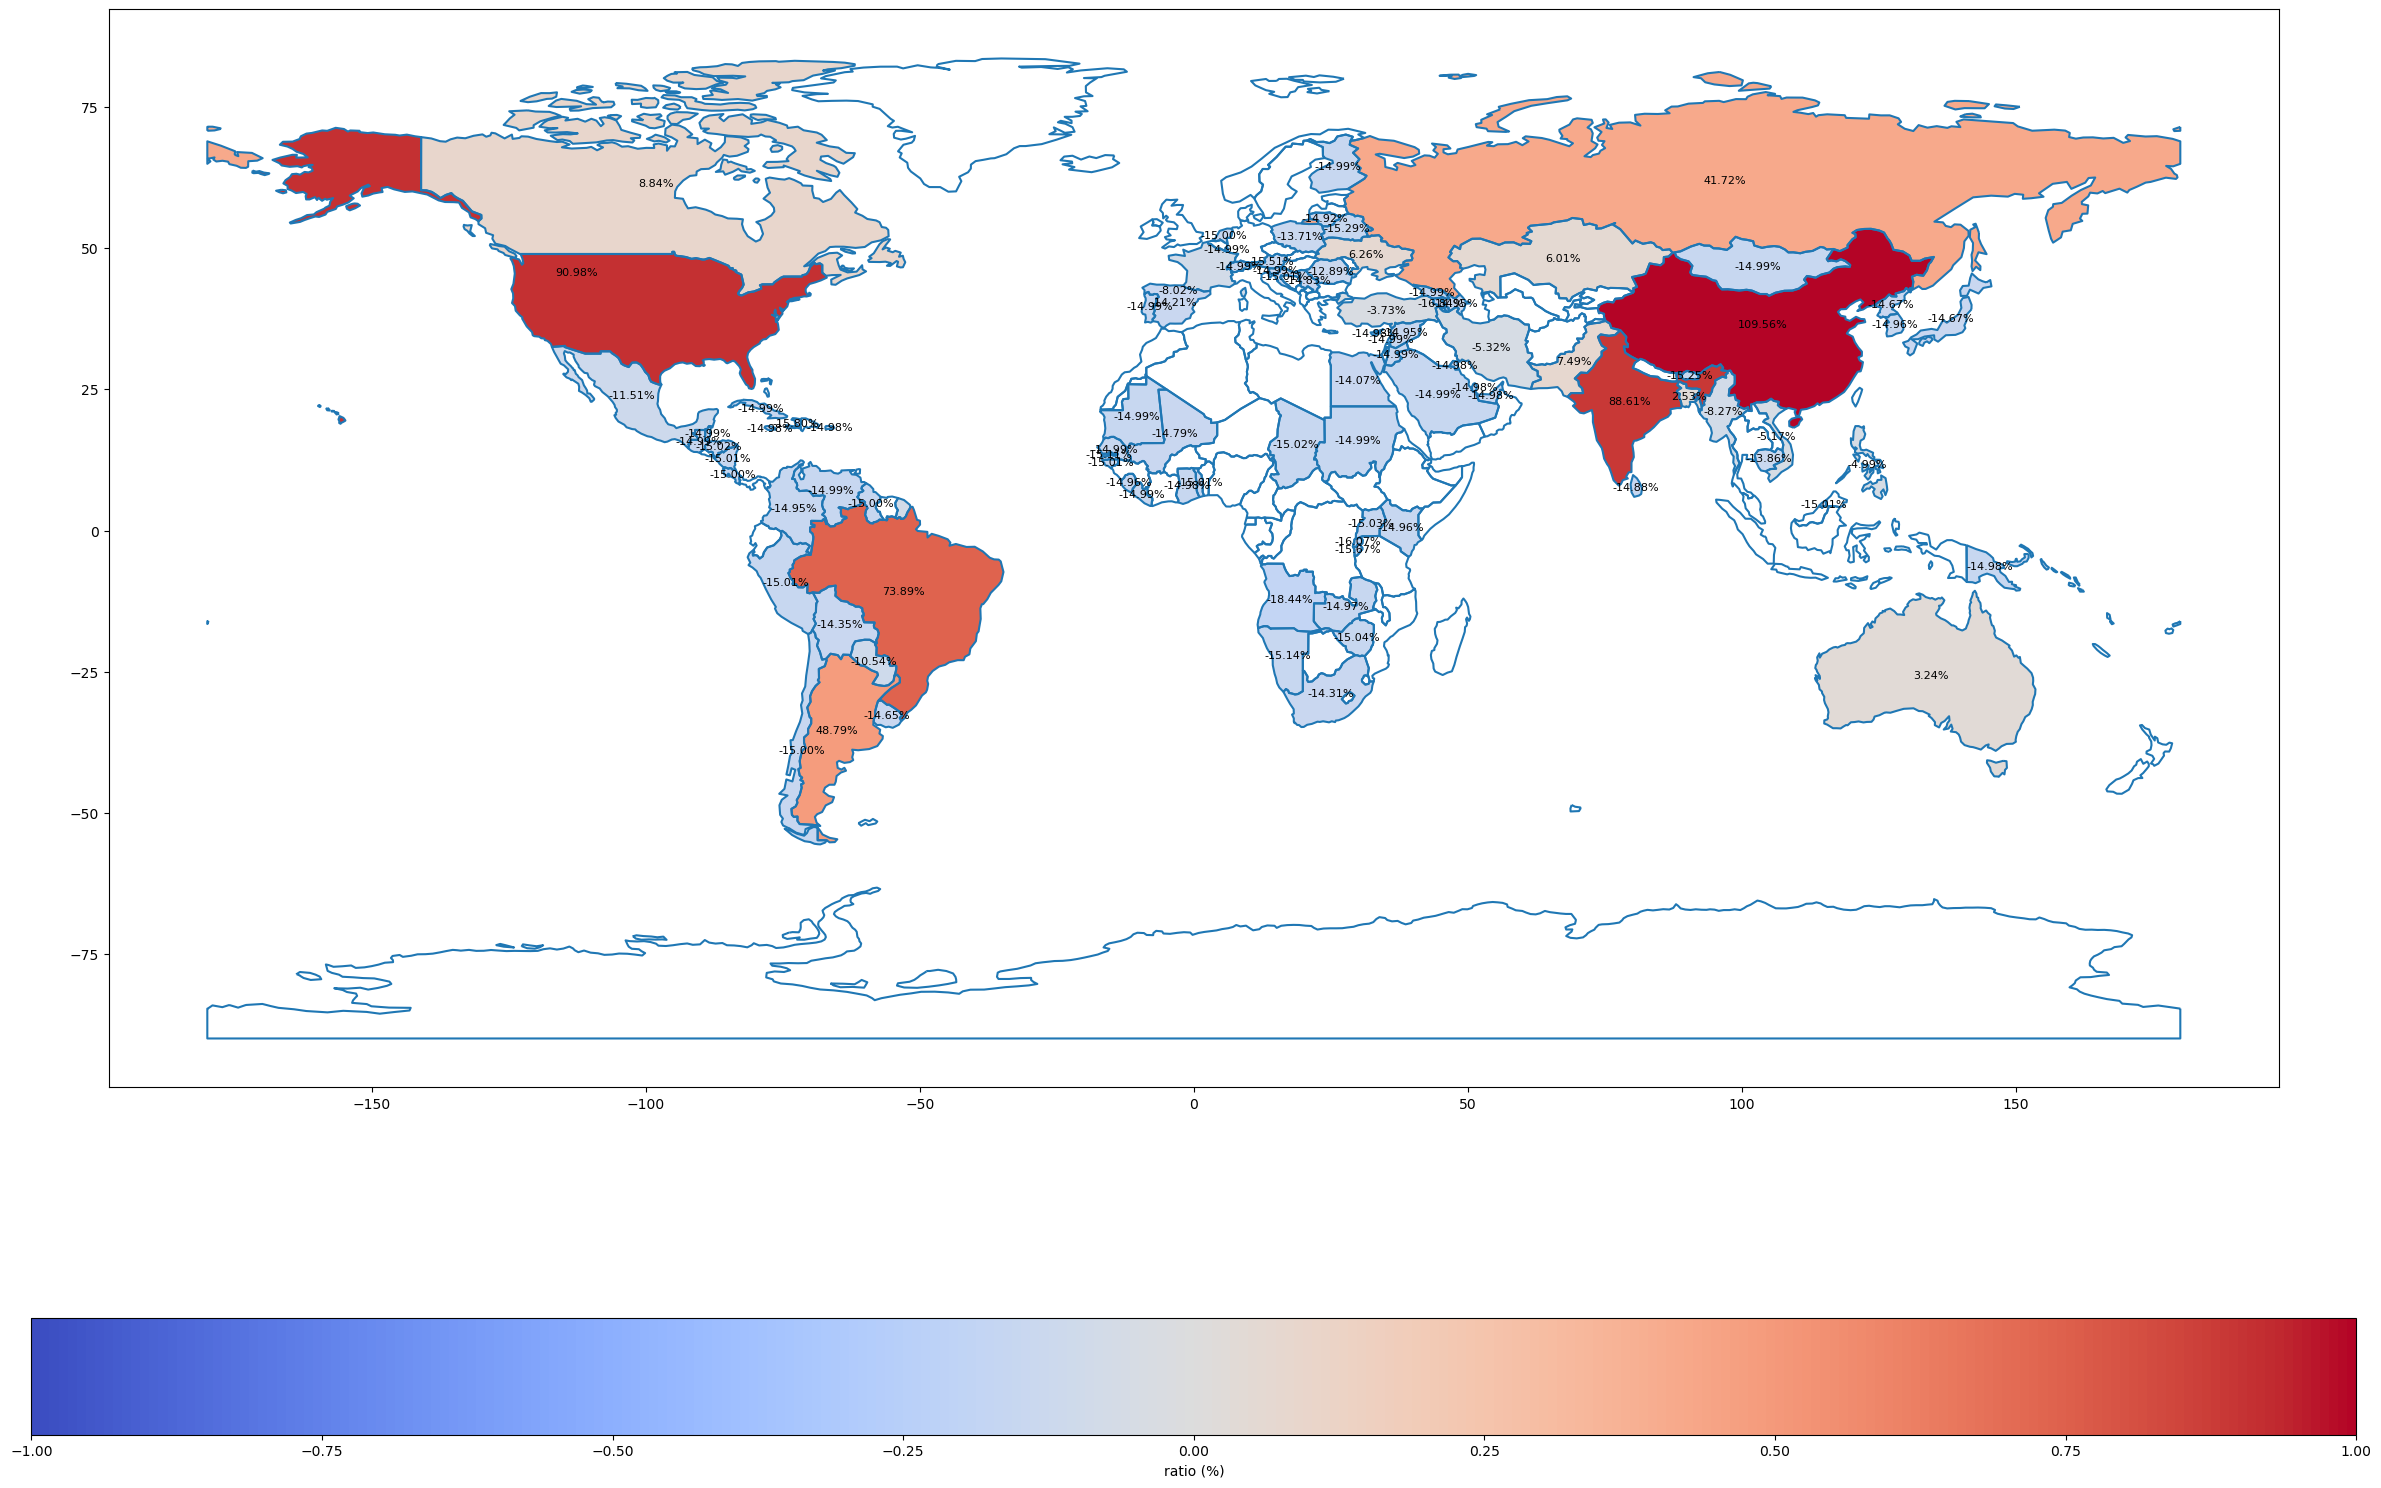

In [74]:
# plot the figure on world map
score_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
score_com['Country'] = score_com['Country'].replace(country_mapping)
score_ratio = score_com[['Country','ratio']]

score_world = score_world.merge(score_ratio, how='left', left_on='name', right_on='Country')

fig, ax = plt.subplots(1, 1, figsize=(30, 20))

score_world.boundary.plot(ax=ax)

vmin, vmax = -1,1
score_world[score_world['ratio'].notnull()].plot(column='ratio', ax=ax, legend=True,
                                                   legend_kwds={'label': "ratio (%)", 'orientation': "horizontal"},
                                    vmin=vmin, vmax=vmax, cmap='coolwarm')
                                    

for x, y, label in zip(score_world[env_world['ratio'].notnull()].geometry.centroid.x,
                       score_world[env_world['ratio'].notnull()].geometry.centroid.y,
                       score_world[env_world['ratio'].notnull()]['ratio']*100):
    ax.text(x, y, f"{label:.2f}%", fontsize=8, ha='center', va='center')

plt.show()